**Mô hình k-means đối với bộ dữ liệu chữ số viết tay**

1. Khai báo các thư viện cần thiết

In [19]:
from __future__ import print_function
import os
import numpy as np
import gzip 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

2. Khai báo đường dẫn đến tệp dữ liệu

In [20]:
data_path = 'D:/Code/python/mat3533/practice09/data/'

train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')

test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

3. Định nghĩa hàm `get_mnist_data` để tải dữ liệu từ tệp gzip chứa hình ảnh và nhãn của bộ dữ liệu

In [21]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    f_images = gzip.open(images_path,'r')
    f_images.read(16)
   
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    buf_images = f_images.read(image_size * image_size * real_num)

    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)

    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)

    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]

    images = images.reshape(num_images, image_size * image_size)
    return images, labels

4. Sử dụng hàm `get_mnist_data` lấy dữ liệu train, test từ tệp dữ liệu

In [22]:
train_images, train_labels = get_mnist_data(
    train_images_path, train_labels_path, 5000)
test_images, test_labels = get_mnist_data(
    test_images_path, test_labels_path, 5000, _is=False)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(5000, 784) (5000,)
(5000, 784) (5000,)


5. Chuẩn hóa dữ liệu

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_images)
test_x = scaler.fit_transform(test_images)

print(train_x.shape)
print(test_x.shape)

(5000, 784)
(5000, 784)


Xây dựng các hàm cho thuật toán k-means

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_x)
train_pca_02 = pca.transform(train_x)
test_pca_02 = pca.transform(test_x)

In [25]:
def kmeans_display(X, label):
    K = np.amax(label) + 1
    for k in range(K):
        Xk = X[label == k, :]
        plt.plot(Xk[:, 0], Xk[:, 1], 'o', label='Cluster {}'.format(k))
    plt.axis('equal')
    plt.legend()

    plt.show()

In [26]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

In [27]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

In [28]:
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

In [29]:
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) ==
    set([tuple(a) for a in new_centers]))

In [30]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break

        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Phân cụm dữ liệu

Centers found by our algorithm:
[[-4.70992231  3.37610793]
 [ 0.53934187  0.1557512 ]
 [-6.34810305 -1.75195765]
 [ 6.34643126 13.08808613]
 [18.04743958  2.75022197]
 [-0.74951994  8.12912464]
 [ 4.89225769 -6.04186249]
 [13.18965626 -7.67132282]
 [-1.64363492 -5.4681201 ]
 [ 7.38038921  2.42185569]]


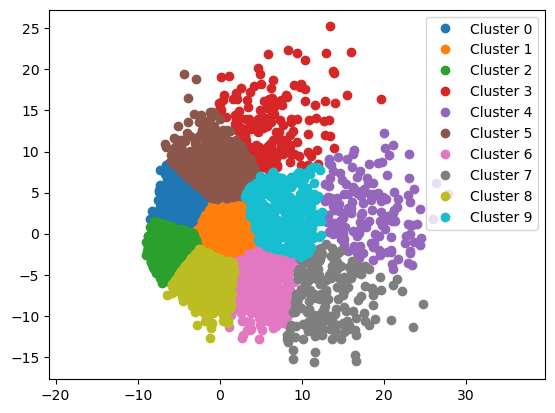

In [31]:
K = 10
(centers, labels, it) = kmeans(train_pca_02, K)
print('Centers found by our algorithm:')
print(centers[-1])
kmeans_display(train_pca_02, labels[-1])